In [224]:
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
from data_reader import load_data_mf, matrix_representation, load_customers_articles, customers_diversification, articles_diversification
from model import TwoTowerFinal, TwoTowerCustomer
from helper import train_two_tower
from recommenders import recommender_two_towers_final,recommender_two_towers_customer
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix

In [198]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 

# Get rare customers so we exclude them from personalized candidates

In [22]:
def get_rare_customers(transactions, threshold=5):
    grouped = transactions.groupby("customer_id")["article_id"].count()
    rare_customers = grouped[grouped<threshold]
    return list(rare_customers.index)
rare_customers = get_rare_customers(transactions, threshold=3)

# Bestsellers depending on the age group and season

In [23]:
def assign_season(x):
    if x in [12,1,2]:
        return 1
    elif x in [3,4,5]:
        return 2
    elif x in [6,7,8]:
        return 3
    else:
        return 4 

In [33]:
def bestsellers_age_season(customers, transactions, rare_customers, set_threshold=0.6):
    cust_age_id = {}
    #get age groups
    bins = [0,25,40,55,float("inf")]
    labels = ["young_preference","adult_preferences","middle_aged_preference","senior_preference"]
    customers["age_group"] = pd.cut(customers["age"], bins=bins, labels=labels, right=False)
    # get season 
    transactions = transactions.merge(customers[["customer_id", "age_group"]], how="left", on="customer_id")
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["month"] = transactions["t_dat"].dt.month 
    transactions["season"] = transactions["month"].apply(assign_season)
    # generate counts for each article_id given age_group and season
    grouped = transactions.groupby(["age_group","season","article_id"], observed=False)["customer_id"].count().reset_index()
    grouped.rename(columns={"customer_id":"transaction_age_count"}, inplace=True)
    # generate ranks given age_group and season
    grouped["age_season_rank"] = grouped.groupby(["age_group","season"],observed=False)["transaction_age_count"].rank(method="dense", ascending=True)
    # scale the ranking
    grouped['max_rank'] = grouped.groupby(['age_group', 'season'], observed=False)['age_season_rank'].transform('max')
    grouped['scaled_age_season_rank'] = grouped['age_season_rank'] / grouped['max_rank']
    # generate customers scores to determine who is buying from bestsellers for given age_group and season
    transactions = transactions.merge(grouped[["age_group","season","article_id","scaled_age_season_rank"]], how="left", on=["age_group","season","article_id"])
    bestseller_propensity = transactions.groupby(["customer_id","age_group"], observed=True)["scaled_age_season_rank"].mean()
    # drop rare customers
    bestseller_propensity = bestseller_propensity.drop(rare_customers, level='customer_id')
    # plot bestseller_propensity
    plt.hist(bestseller_propensity.values, bins=30, color='purple', edgecolor='black')
    plt.xlabel('Bestseller Propensity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Bestseller Propensity')
    plt.grid(True)
    plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
    plt.legend()
    plt.show()
    # get customers with high propensity score
    customers_id = np.array(list(bestseller_propensity[bestseller_propensity>0.6].index.get_level_values('customer_id')))
    for label in labels:
        cust_age_id[label] = bestseller_propensity[(bestseller_propensity>0.6)&(bestseller_propensity.index.get_level_values('age_group') == label)].index.get_level_values('customer_id')
    return bestseller_propensity, customers_id, cust_age_id
    

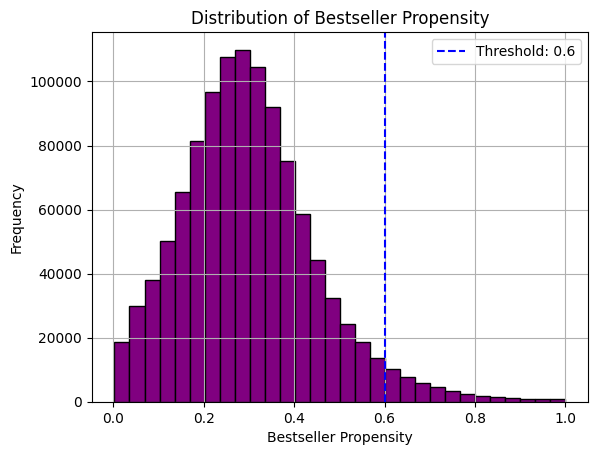

In [199]:
bestseller_propensity, all_cust_age_season, age_season_cust = bestsellers_age_season(customers, transactions, rare_customers) 

# Customers buying from specific clothes section

In [115]:
def index_preferences(transactions, articles, customers, rare_customers, set_threshold=0.8):
    transactions = transactions.merge(articles[["article_id", "index_name"]], how="left", on="article_id")
    grouped = transactions.groupby(["customer_id", "index_name"])["article_id"].count()
    percentages = grouped/grouped.groupby(level=0).transform("sum")
    percentages = percentages.drop(index=rare_customers, level='customer_id')
    # get menswear 
    manswear = percentages[percentages.index.get_level_values('index_name') == 3]
    manswear = manswear.rename("manswear")
    customers = customers.merge(manswear, how="left", on="customer_id")
    customers["manswear"] = customers["manswear"].fillna(0)
    # get ledieswear
    ladieswear = percentages[percentages.index.get_level_values('index_name').isin([0,1,4])].groupby("customer_id").sum()
    ladieswear = ladieswear.rename("ladieswear")
    customers = customers.merge(ladieswear, how="left", on="customer_id")
    customers["ladieswear"] = customers["ladieswear"].fillna(0)
    # get kids 
    kids = percentages[percentages.index.get_level_values('index_name').isin([2,6,8,9])].groupby("customer_id").sum()
    kids = kids.rename("kids")
    customers = customers.merge(kids, how="left", on="customer_id")
    customers["kids"] = customers["kids"].fillna(0)
    # get divided 
    divided = percentages[percentages.index.get_level_values('index_name') == 7]
    divided = divided.rename("divided")
    customers = customers.merge(divided, how="left", on="customer_id")
    customers["divided"] = customers["divided"].fillna(0)
    # get sport 
    sport = percentages[percentages.index.get_level_values('index_name') == 5]
    sport = sport.rename("sport")
    customers = customers.merge(sport, how="left", on="customer_id")
    customers["sport"] = customers["sport"].fillna(0)

    # plot plots distribution of index preferences
    indices = ["manswear","ladieswear","kids","divided","sport"]
    for index in indices:
        plt.hist(customers[index], bins=30, color='purple', edgecolor='black')
        plt.xlabel(f'Percentage of sold {index} products')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {index} products')
        plt.grid(True)
        plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
        plt.legend()
        plt.show()
    
    mens = customers["customer_id"][customers["manswear"]>set_threshold].values
    ladies = customers["customer_id"][customers["ladieswear"]>set_threshold].values
    kid = customers["customer_id"][customers["kids"]>set_threshold].values
    div = customers["customer_id"][customers["divided"]>set_threshold].values
    sprt = customers["customer_id"][customers["sport"]>set_threshold].values
    return mens, ladies, kid, div, sprt  



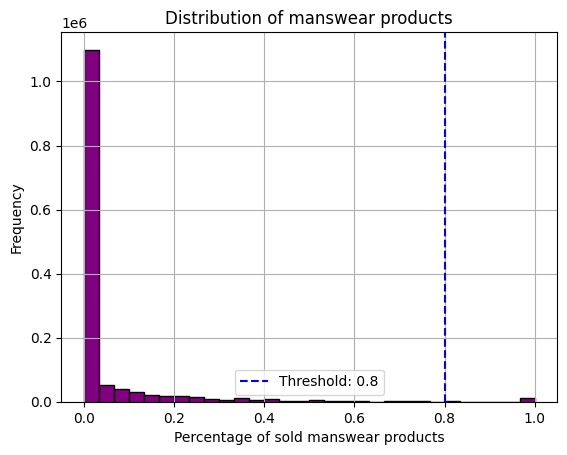

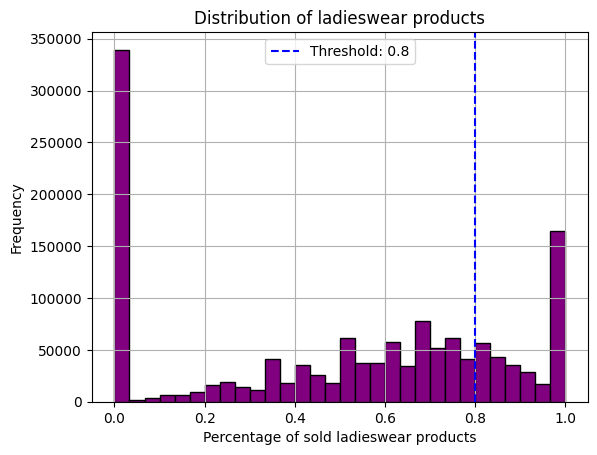

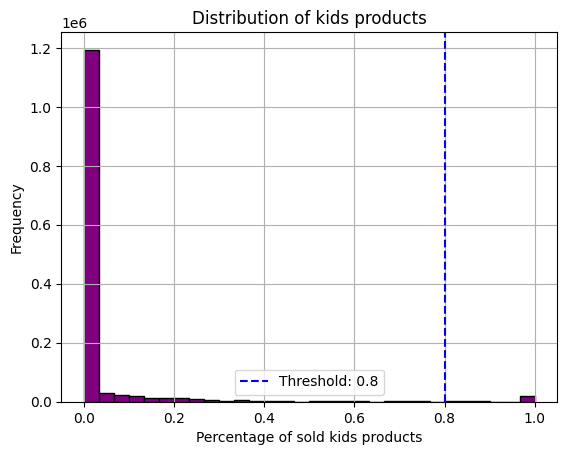

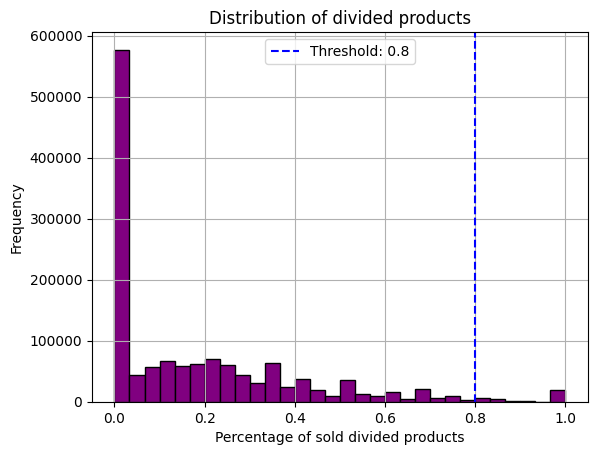

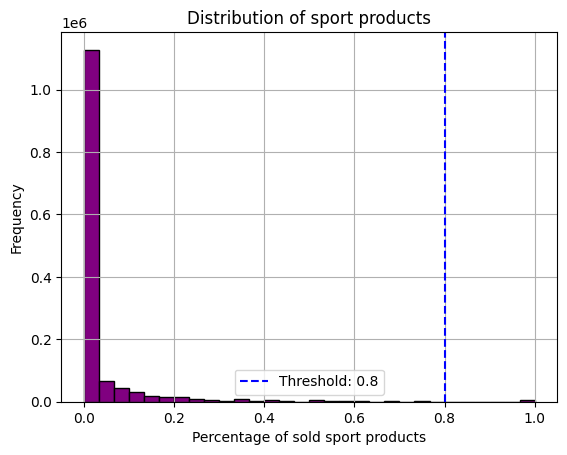

In [116]:
mens, ladies, kid, div, sport = index_preferences(transactions, articles, customers, rare_customers, set_threshold=0.8)

# Discount hunters

In [117]:
def get_discount_hunters(transactions, rare_customers, set_threshold=0.8):
    # determine if the product was sold with discounted price
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["month"] = transactions["t_dat"].dt.month 
    transactions["season"] = transactions["month"].apply(assign_season)
    grouped = transactions.groupby(["article_id","season"])["price"].median()
    grouped = grouped.rename("normal_price")
    transactions = transactions.merge(grouped, on=["article_id","season"], how="left")
    transactions["price_discount"] = transactions["price"] - transactions["normal_price"]
    transactions["price_discount"] = transactions["price_discount"]<0
    # get percentages of discounted products bought by customer
    grouped = transactions.groupby(["customer_id","price_discount"])["article_id"].count()
    percentages = grouped/grouped.groupby(level=0).transform("sum")
    percentages = percentages.drop(index=rare_customers, level='customer_id')
    discounted_percentages = percentages[percentages.index.get_level_values('price_discount') == 1]
    # print distribution
    plt.hist(discounted_percentages.values, bins=30, color='purple', edgecolor='black')
    plt.xlabel('Discount Percentage')
    plt.ylabel('Frequency')
    plt.title('Distribution of Discount Percentage')
    plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
    plt.grid(True)
    plt.legend()
    plt.show()
    # get customers indices
    discount_hunters = np.array(list(discounted_percentages[discounted_percentages>set_threshold].index.get_level_values('customer_id')))
    return discount_hunters

In [12]:
# def get_discount_hunters(transactions, rare_customers, set_threshold=0.8):
#     # get delayed prices
#     transactions.sort_values(by=['article_id', 't_dat'], inplace=True)
#     transactions['prev_price'] = transactions.groupby('article_id')['price'].shift(1)
#     # check if there was drop of the price indicating discount
#     transactions['price_discount'] = transactions['price'] - transactions['prev_price']
#     transactions = transactions.drop(columns=["prev_price"])
#     transactions["price_discount"] = transactions["price_discount"].fillna(0)
#     transactions["price_discount"] = transactions["price_discount"].apply(lambda x: 1 if x < 0 else 0)
#     # get percentages of discounted products bought by customer
#     grouped = transactions.groupby(["customer_id","price_discount"])["article_id"].count()
#     percentages = grouped/grouped.groupby(level=0).transform("sum")
#     percentages = percentages.drop(index=rare_customers, level='customer_id')
#     discounted_percentages = percentages[percentages.index.get_level_values('price_discount') == 1]
#     # print distribution
#     plt.hist(discounted_percentages.values, bins=30, color='purple', edgecolor='black')
#     plt.xlabel('Discount Percentage')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Discount Percentage')
#     plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
#     # get customers indices
#     discount_hunters = np.array(list(discounted_percentages[discounted_percentages>set_threshold].index.get_level_values('customer_id')))
#     return discount_hunters

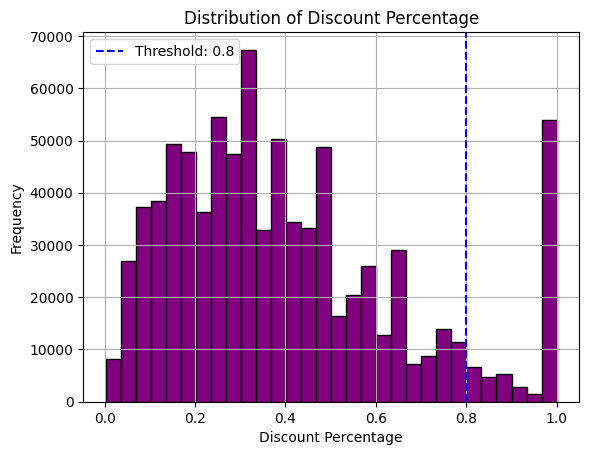

In [118]:
discount_hunters = get_discount_hunters(transactions, rare_customers)

# Seasonal customers

In [132]:
def seasonal_customers(transactions,rare_customers,set_threshold=0.8):
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["month"] = transactions["t_dat"].dt.month 
    transactions["season"] = transactions["month"].apply(assign_season)
    grouped = transactions.groupby(["customer_id","season"])["article_id"].count()
    percentages = grouped/grouped.groupby(level=0).transform("sum")
    percentages = percentages.drop(index=rare_customers, level='customer_id')
    seasons = ["winter","spring","summer","autumn"]
    cust_ids = []
    for i, season in enumerate(seasons):
        season_perc = percentages[percentages.index.get_level_values('season') == i+1]
        season_perc = season_perc.rename(f"{season}_perc")
        # plot distribution of the season perc
        plt.hist(season_perc.values, bins=30, color='purple', edgecolor='black')
        plt.xlabel(season)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {season}')
        plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
        plt.grid(True)
        plt.legend()
        plt.show()
        # append customer_ids 
        cust_ids.append(season_perc[season_perc>set_threshold].index.get_level_values("customer_id"))
    return cust_ids

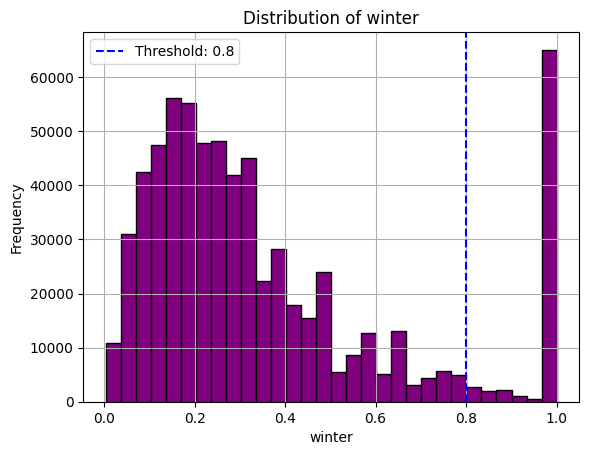

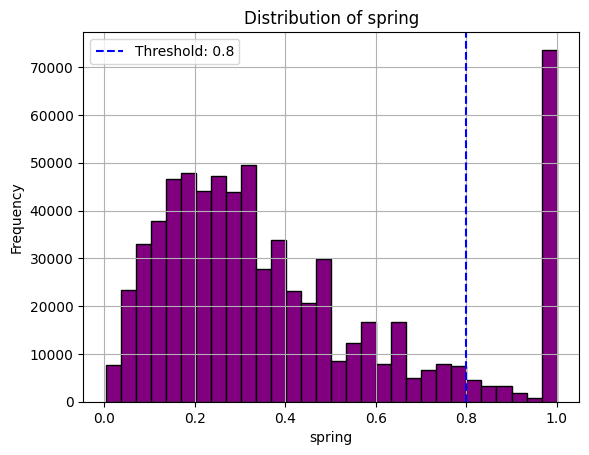

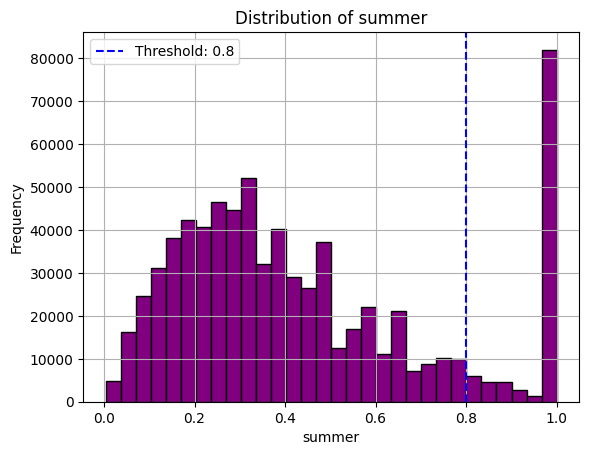

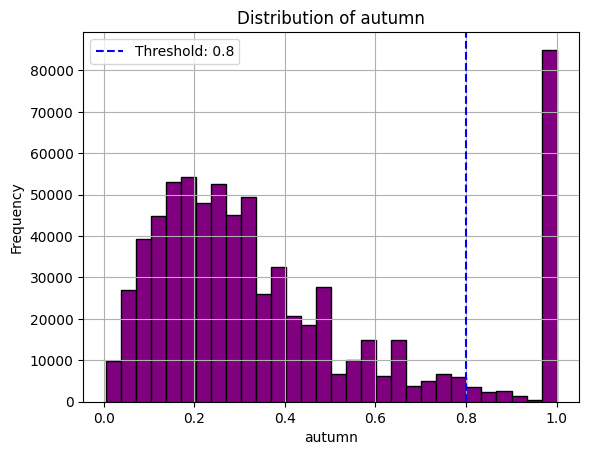

In [133]:
season_ids = seasonal_customers(transactions, rare_customers)

# Article candidates for recommendations

### Age Articles

In [40]:
def age_article_candidates(customers, transactions, date_thershold='2020-08-22', article_threshold=500):
    #get age groups
    bins = [0,25,40,55,float("inf")]
    labels = ["young_preference","adult_preferences","middle_aged_preference","senior_preference"]
    customers["age_group"] = pd.cut(customers["age"], bins=bins, labels=labels, right=False)
    # get resent 
    transactions = transactions.merge(customers[["customer_id", "age_group"]], how="left", on="customer_id")
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["month"] = transactions["t_dat"].dt.month 
    transactions["year"] = transactions["t_dat"].dt.year 
    transactions["season"] = transactions["month"].apply(assign_season)
    transactions = transactions[transactions.t_dat>date_thershold]
    grouped = transactions.groupby(["age_group","article_id"], observed=False)["customer_id"].count().reset_index()
    grouped.rename(columns={"customer_id":"transaction_age_count"}, inplace=True)
    # generate ranks given age_group and season
    grouped["age_season_rank"] = grouped.groupby(["age_group"],observed=False)["transaction_age_count"].rank(method="dense", ascending=True)
    article_age_indices = {}
    for label in labels:
        label_grouped = grouped[grouped.age_group==label].sort_values("age_season_rank", ascending=False)
        article_age_indices[label] = label_grouped["article_id"][0:article_threshold].values
    return article_age_indices
        

In [72]:
article_age_indices = age_article_candidates(customers, transactions, date_thershold='2020-08-22', article_threshold=1000)

### Discounted Articles

In [171]:
def get_discounted_articles(transactions, date_threshold='2020-08-22'):
    transactions = transactions[transactions["t_dat"]>date_threshold]
    grouped = transactions.groupby("article_id")["price"].median()
    grouped = grouped.rename("normal_price")
    transactions = transactions.merge(grouped, on="article_id", how="left")
    transactions["price_discount"] = transactions["price"] - transactions["normal_price"]
    discounted_articles = transactions[transactions["price_discount"]<0]["article_id"].values
    return list(discounted_articles)
    

In [172]:
discounted_articles = get_discounted_articles(transactions, date_threshold='2020-08-22')

### Seasonal articles

In [180]:
def get_season_articles(transactions, season="autumn", set_threshold=0.8):
    season_id = {"winter":1,"spring":2,"summer":3,"autumn":4}
    transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
    transactions["month"] = transactions["t_dat"].dt.month 
    transactions["year"] = transactions["t_dat"].dt.year 
    transactions["season"] = transactions["month"].apply(assign_season)
    grouped = transactions.groupby(["article_id","season"])["customer_id"].count()
    percentages = grouped/grouped.groupby(level=0).transform("sum")
    season_perc = percentages[percentages.index.get_level_values('season') == season_id[season]]
    season_perc = season_perc.rename(f"{season}_perc")
    # plot distribution of the season perc
    plt.hist(season_perc.values, bins=30, color='purple', edgecolor='black')
    plt.xlabel(season)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {season}')
    plt.axvline(x=set_threshold, color='blue', linestyle='--', label=f'Threshold: {set_threshold}')
    plt.grid(True)
    plt.legend()
    plt.show()
    # append customer_ids 
    return season_perc[season_perc>set_threshold].index.get_level_values("article_id")

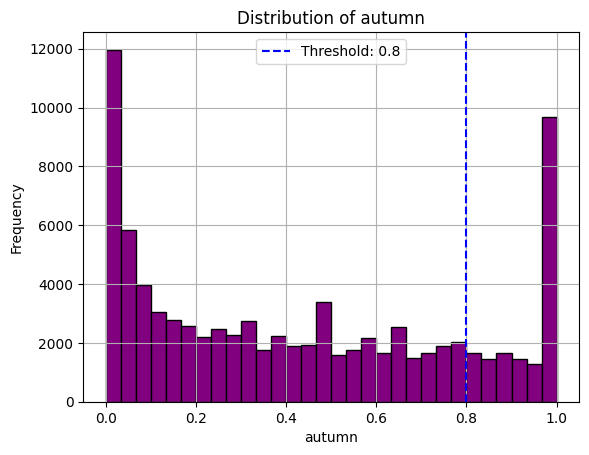

In [181]:
season_articles = get_season_articles(transactions, season="autumn", set_threshold=0.8)

# Training

In [209]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 
articles = articles_diversification(articles, transactions, customers)
customers = customers_diversification(customers, transactions, articles)


# generate candidates
menswear_articles = list(articles[articles.index_name==3].article_id)
ladieswear_articles = list(articles[articles.index_name.isin([0,1,4])].article_id)
kidswear_articles = list(articles[articles.index_name.isin([2,6,8,9])].article_id)
divide_articles = list(articles[articles.index_name==7].article_id)
sportwear_articles = list(articles[articles.index_name==5].article_id)
young_bestsellers = list(articles[articles.index_name==5].article_id)
# Best sellers from last month
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
bestseller_candidates = list(grouped_counts.sort_values(ascending=False)[0:1000].index)

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

articles_categorical = ["product_type_name","graphical_appearance_name",
                        "perceived_colour_master_name","department_name",
                        "index_name","section_name","garment_group_name"]

articles_cont = ['winter_sale', 'spring_sale','summer_sale', 'autumn_sale',
                'avg_price','young_preference', 'adult_preferences', 
                'middle_aged_preference','senior_preference', 
                'sales_channel_2', 'sales_channel_1']

min_max_cols = ['rank_3_2020', 'rank_4_2020']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), articles_categorical),
        ('cont', 'passthrough', articles_cont),
        ("min_max", MinMaxScaler(), min_max_cols)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
articles = csr_matrix(preprocessor.fit_transform(articles))

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

AGE GROUP DISTRIBUTION

age_group
adult_preferences         492701
young_preference          357169
middle_aged_preference    339444
senior_preference         182666
Name: count, dtype: int64


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:609: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = t.groupby(["article_id", "age_group"])["customer_id"].count()


In [94]:
# deep architecture
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

### 1. Bestsellers depending on the age group

#### 1.1 Young Preference

#### - Deep Customer Tower

In [ ]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerYoung2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

#### - Shallow Customer Tower

In [222]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerYoung1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 393/393 [00:06<00:00, 56.94it/s]


Epoch [1/10] - Train Loss: 0.0550, Validation Loss: 0.0474


100%|██████████| 393/393 [00:06<00:00, 58.01it/s]


Epoch [2/10] - Train Loss: 0.0527, Validation Loss: 0.0450


100%|██████████| 393/393 [00:06<00:00, 57.70it/s]


Epoch [3/10] - Train Loss: 0.0511, Validation Loss: 0.0443


100%|██████████| 393/393 [00:06<00:00, 57.91it/s]


Epoch [4/10] - Train Loss: 0.0490, Validation Loss: 0.0439


100%|██████████| 393/393 [00:06<00:00, 59.13it/s]


Epoch [5/10] - Train Loss: 0.0471, Validation Loss: 0.0426


100%|██████████| 393/393 [00:06<00:00, 57.31it/s]


Epoch [6/10] - Train Loss: 0.0456, Validation Loss: 0.0423


100%|██████████| 393/393 [00:06<00:00, 57.93it/s]


Epoch [7/10] - Train Loss: 0.0437, Validation Loss: 0.0419


100%|██████████| 393/393 [00:06<00:00, 58.33it/s]


Epoch [8/10] - Train Loss: 0.0420, Validation Loss: 0.0415


100%|██████████| 393/393 [00:06<00:00, 58.20it/s]


Epoch [9/10] - Train Loss: 0.0409, Validation Loss: 0.0415


100%|██████████| 393/393 [00:06<00:00, 57.49it/s]


Epoch [10/10] - Train Loss: 0.0403, Validation Loss: 0.0408


#### - Recommend with different settings

In [229]:
# load model
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
# get shallow model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerYoung2.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get last sold restriction
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 15/15 [00:00<00:00, 236.69it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 236.93it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Precision: 0.019330186558777253
Recall: 0.008420846490905975


In [259]:
# load model
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
# get deep model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerYoung.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get last sold items restriction
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 15/15 [00:00<00:00, 175.40it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 218.26it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Precision: 0.013654753877275792
Recall: 0.005948446794448116


In [227]:
# load model
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
# get shallow model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerYoung2.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# add top sold articles based on the age group as restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["young_preference"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 15/15 [00:00<00:00, 190.16it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 239.83it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


Precision: 0.015677680377612947
Recall: 0.006829698171403393


In [261]:
# load model
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
# get deep model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerYoung.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# add top sold articles based on the age group as restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["young_preference"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 15/15 [00:00<00:00, 194.55it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 235.93it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Precision: 0.015677680377612947
Recall: 0.006829698171403393


#### 1.2 Adult Preferences

In [104]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["adult_preferences"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerAdult1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 423/423 [00:06<00:00, 62.84it/s]


Epoch [1/10] - Train Loss: 0.0735, Validation Loss: 0.0650


100%|██████████| 423/423 [00:06<00:00, 63.74it/s]


Epoch [2/10] - Train Loss: 0.0717, Validation Loss: 0.0617


100%|██████████| 423/423 [00:06<00:00, 61.56it/s]


Epoch [3/10] - Train Loss: 0.0637, Validation Loss: 0.0588


100%|██████████| 423/423 [00:06<00:00, 61.57it/s]


Epoch [4/10] - Train Loss: 0.0581, Validation Loss: 0.0577


100%|██████████| 423/423 [00:06<00:00, 64.64it/s]


Epoch [5/10] - Train Loss: 0.0553, Validation Loss: 0.0570


100%|██████████| 423/423 [00:06<00:00, 63.94it/s]


Epoch [6/10] - Train Loss: 0.0507, Validation Loss: 0.0556


100%|██████████| 423/423 [00:06<00:00, 62.18it/s]


Epoch [7/10] - Train Loss: 0.0487, Validation Loss: 0.0553


100%|██████████| 423/423 [00:06<00:00, 61.61it/s]


Epoch [8/10] - Train Loss: 0.0472, Validation Loss: 0.0550


100%|██████████| 423/423 [00:06<00:00, 62.55it/s]


Epoch [9/10] - Train Loss: 0.0443, Validation Loss: 0.0549


100%|██████████| 423/423 [00:06<00:00, 61.66it/s]


Epoch [10/10] - Train Loss: 0.0417, Validation Loss: 0.0546


In [245]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["adult_preferences"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerAdult2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 423/423 [00:07<00:00, 56.76it/s]


Epoch [1/10] - Train Loss: 0.0731, Validation Loss: 0.0658


100%|██████████| 423/423 [00:07<00:00, 56.87it/s]


Epoch [2/10] - Train Loss: 0.0696, Validation Loss: 0.0618


100%|██████████| 423/423 [00:07<00:00, 59.20it/s]


Epoch [3/10] - Train Loss: 0.0689, Validation Loss: 0.0605


100%|██████████| 423/423 [00:07<00:00, 55.44it/s]


Epoch [4/10] - Train Loss: 0.0598, Validation Loss: 0.0578


100%|██████████| 423/423 [00:07<00:00, 55.19it/s]


Epoch [5/10] - Train Loss: 0.0557, Validation Loss: 0.0569


100%|██████████| 423/423 [00:07<00:00, 56.18it/s]


Epoch [6/10] - Train Loss: 0.0538, Validation Loss: 0.0565


100%|██████████| 423/423 [00:07<00:00, 56.01it/s]


Epoch [7/10] - Train Loss: 0.0526, Validation Loss: 0.0565


100%|██████████| 423/423 [00:07<00:00, 55.55it/s]


Epoch [8/10] - Train Loss: 0.0503, Validation Loss: 0.0559


100%|██████████| 423/423 [00:07<00:00, 57.77it/s]


Epoch [9/10] - Train Loss: 0.0468, Validation Loss: 0.0556


100%|██████████| 423/423 [00:07<00:00, 56.07it/s]


Epoch [10/10] - Train Loss: 0.0445, Validation Loss: 0.0552


In [105]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerAdult.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 16/16 [00:00<00:00, 201.72it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 231.63it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Precision: 0.018227461253001526
Recall: 0.007699223162213872


In [106]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerAdult.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["adult_preferences"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 16/16 [00:00<00:00, 220.31it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 234.44it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


Precision: 0.021556428727352108
Recall: 0.009105368709803831


#### 1.3 Middle Aged Preference

In [101]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["middle_aged_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerMiddle1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 213/213 [00:03<00:00, 61.17it/s]


Epoch [1/10] - Train Loss: 0.0618, Validation Loss: 0.0641


100%|██████████| 213/213 [00:03<00:00, 64.08it/s]


Epoch [2/10] - Train Loss: 0.0546, Validation Loss: 0.0612


100%|██████████| 213/213 [00:03<00:00, 63.35it/s]


Epoch [3/10] - Train Loss: 0.0533, Validation Loss: 0.0567


100%|██████████| 213/213 [00:03<00:00, 62.95it/s]


Epoch [4/10] - Train Loss: 0.0539, Validation Loss: 0.0554


100%|██████████| 213/213 [00:03<00:00, 64.82it/s]


Epoch [5/10] - Train Loss: 0.0502, Validation Loss: 0.0535


100%|██████████| 213/213 [00:03<00:00, 65.23it/s]


Epoch [6/10] - Train Loss: 0.0473, Validation Loss: 0.0528


100%|██████████| 213/213 [00:03<00:00, 65.26it/s]


Epoch [7/10] - Train Loss: 0.0465, Validation Loss: 0.0525


100%|██████████| 213/213 [00:03<00:00, 65.04it/s]


Epoch [8/10] - Train Loss: 0.0456, Validation Loss: 0.0524


100%|██████████| 213/213 [00:03<00:00, 65.10it/s]


Epoch [9/10] - Train Loss: 0.0451, Validation Loss: 0.0522


100%|██████████| 213/213 [00:03<00:00, 65.13it/s]


Epoch [10/10] - Train Loss: 0.0429, Validation Loss: 0.0515


In [246]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["middle_aged_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerMiddle2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 213/213 [00:03<00:00, 53.49it/s]


Epoch [1/10] - Train Loss: 0.0605, Validation Loss: 0.0629


100%|██████████| 213/213 [00:03<00:00, 56.37it/s]


Epoch [2/10] - Train Loss: 0.0556, Validation Loss: 0.0600


100%|██████████| 213/213 [00:03<00:00, 53.57it/s]


Epoch [3/10] - Train Loss: 0.0538, Validation Loss: 0.0575


100%|██████████| 213/213 [00:03<00:00, 56.07it/s]


Epoch [4/10] - Train Loss: 0.0536, Validation Loss: 0.0548


100%|██████████| 213/213 [00:03<00:00, 54.85it/s]


Epoch [5/10] - Train Loss: 0.0520, Validation Loss: 0.0545


100%|██████████| 213/213 [00:03<00:00, 53.99it/s]


Epoch [6/10] - Train Loss: 0.0497, Validation Loss: 0.0541


100%|██████████| 213/213 [00:03<00:00, 55.18it/s]


Epoch [7/10] - Train Loss: 0.0477, Validation Loss: 0.0533


100%|██████████| 213/213 [00:03<00:00, 57.71it/s]


Epoch [8/10] - Train Loss: 0.0463, Validation Loss: 0.0533


100%|██████████| 213/213 [00:03<00:00, 58.87it/s]


Epoch [9/10] - Train Loss: 0.0457, Validation Loss: 0.0530


100%|██████████| 213/213 [00:03<00:00, 59.05it/s]


Epoch [10/10] - Train Loss: 0.0445, Validation Loss: 0.0531


In [102]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerMiddle.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 9/9 [00:00<00:00, 235.81it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 235.93it/s]


Get recommendations...


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Precision: 0.016049382716049384
Recall: 0.0070947789703474625


In [103]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerMiddle.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["middle_aged_preference"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 9/9 [00:00<00:00, 255.46it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 238.78it/s]


Get recommendations...


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Precision: 0.015432098765432098
Recall: 0.006821902856103329


#### 1.4 Senior Preference

In [107]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["senior_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSenior1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 90/90 [00:01<00:00, 56.27it/s]


Epoch [1/10] - Train Loss: 0.0608, Validation Loss: 0.0537


100%|██████████| 90/90 [00:01<00:00, 61.74it/s]


Epoch [2/10] - Train Loss: 0.0478, Validation Loss: 0.0466


100%|██████████| 90/90 [00:01<00:00, 64.09it/s]


Epoch [3/10] - Train Loss: 0.0438, Validation Loss: 0.0441


100%|██████████| 90/90 [00:01<00:00, 62.13it/s]


Epoch [4/10] - Train Loss: 0.0425, Validation Loss: 0.0428


100%|██████████| 90/90 [00:01<00:00, 63.68it/s]


Epoch [5/10] - Train Loss: 0.0412, Validation Loss: 0.0422


100%|██████████| 90/90 [00:01<00:00, 60.68it/s]


Epoch [6/10] - Train Loss: 0.0398, Validation Loss: 0.0420


100%|██████████| 90/90 [00:01<00:00, 64.45it/s]


Epoch [7/10] - Train Loss: 0.0388, Validation Loss: 0.0417


100%|██████████| 90/90 [00:01<00:00, 62.33it/s]


Epoch [8/10] - Train Loss: 0.0377, Validation Loss: 0.0411


100%|██████████| 90/90 [00:01<00:00, 62.19it/s]


Epoch [9/10] - Train Loss: 0.0372, Validation Loss: 0.0409


100%|██████████| 90/90 [00:01<00:00, 54.63it/s]


Epoch [10/10] - Train Loss: 0.0373, Validation Loss: 0.0406


In [247]:
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["senior_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSenior2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 90/90 [00:01<00:00, 57.97it/s]


Epoch [1/10] - Train Loss: 0.0612, Validation Loss: 0.0536


100%|██████████| 90/90 [00:01<00:00, 53.45it/s]


Epoch [2/10] - Train Loss: 0.0496, Validation Loss: 0.0468


100%|██████████| 90/90 [00:01<00:00, 58.23it/s]


Epoch [3/10] - Train Loss: 0.0458, Validation Loss: 0.0447


100%|██████████| 90/90 [00:01<00:00, 58.18it/s]


Epoch [4/10] - Train Loss: 0.0430, Validation Loss: 0.0427


100%|██████████| 90/90 [00:01<00:00, 57.97it/s]


Epoch [5/10] - Train Loss: 0.0417, Validation Loss: 0.0420


100%|██████████| 90/90 [00:01<00:00, 58.19it/s]


Epoch [6/10] - Train Loss: 0.0404, Validation Loss: 0.0417


100%|██████████| 90/90 [00:01<00:00, 57.87it/s]


Epoch [7/10] - Train Loss: 0.0401, Validation Loss: 0.0414


100%|██████████| 90/90 [00:01<00:00, 58.02it/s]


Epoch [8/10] - Train Loss: 0.0393, Validation Loss: 0.0409


100%|██████████| 90/90 [00:01<00:00, 58.27it/s]


Epoch [9/10] - Train Loss: 0.0382, Validation Loss: 0.0408


100%|██████████| 90/90 [00:01<00:00, 58.41it/s]


Epoch [10/10] - Train Loss: 0.0373, Validation Loss: 0.0406


In [108]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerSenior.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 4/4 [00:00<00:00, 151.18it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 233.88it/s]


Get recommendations...


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


Precision: 0.020544783010156973
Recall: 0.009370393767108865


In [109]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerSenior.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["senior_preference"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 4/4 [00:00<00:00, 249.24it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 236.68it/s]


Get recommendations...


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


Precision: 0.017774699907663897
Recall: 0.008106969888397557


### 2. Customers buying from specific clothes section

#### 2.1 Menswear

In [136]:
mens_trans = transactions_negatives[transactions_negatives.customer_id.isin(mens)]
train_dataloader, val_dataloader, test_customers = load_data_mf(mens_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerMens1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=15)

100%|██████████| 299/299 [00:04<00:00, 65.93it/s]


Epoch [1/15] - Train Loss: 0.0507, Validation Loss: 0.0527


100%|██████████| 299/299 [00:04<00:00, 66.16it/s]


Epoch [2/15] - Train Loss: 0.0422, Validation Loss: 0.0473


100%|██████████| 299/299 [00:04<00:00, 66.57it/s]


Epoch [3/15] - Train Loss: 0.0435, Validation Loss: 0.0435


100%|██████████| 299/299 [00:04<00:00, 65.06it/s]


Epoch [4/15] - Train Loss: 0.0452, Validation Loss: 0.0424


100%|██████████| 299/299 [00:04<00:00, 66.10it/s]


Epoch [5/15] - Train Loss: 0.0428, Validation Loss: 0.0410


100%|██████████| 299/299 [00:04<00:00, 66.40it/s]


Epoch [6/15] - Train Loss: 0.0383, Validation Loss: 0.0405


100%|██████████| 299/299 [00:04<00:00, 66.03it/s]


Epoch [7/15] - Train Loss: 0.0353, Validation Loss: 0.0399


100%|██████████| 299/299 [00:04<00:00, 66.38it/s]


Epoch [8/15] - Train Loss: 0.0310, Validation Loss: 0.0392


100%|██████████| 299/299 [00:04<00:00, 66.33it/s]


Epoch [9/15] - Train Loss: 0.0268, Validation Loss: 0.0384


100%|██████████| 299/299 [00:04<00:00, 66.29it/s]


Epoch [10/15] - Train Loss: 0.0229, Validation Loss: 0.0375


100%|██████████| 299/299 [00:04<00:00, 66.16it/s]


Epoch [11/15] - Train Loss: 0.0204, Validation Loss: 0.0370


100%|██████████| 299/299 [00:04<00:00, 64.89it/s]


Epoch [12/15] - Train Loss: 0.0200, Validation Loss: 0.0368


100%|██████████| 299/299 [00:04<00:00, 66.21it/s]


Epoch [13/15] - Train Loss: 0.0199, Validation Loss: 0.0376


100%|██████████| 299/299 [00:04<00:00, 66.22it/s]


Epoch [14/15] - Train Loss: 0.0193, Validation Loss: 0.0404


100%|██████████| 299/299 [00:04<00:00, 66.48it/s]


Epoch [15/15] - Train Loss: 0.0164, Validation Loss: 0.0412


In [248]:
mens_trans = transactions_negatives[transactions_negatives.customer_id.isin(mens)]
train_dataloader, val_dataloader, test_customers = load_data_mf(mens_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerMens2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 299/299 [00:05<00:00, 57.85it/s]


Epoch [1/10] - Train Loss: 0.0501, Validation Loss: 0.0503


100%|██████████| 299/299 [00:05<00:00, 57.58it/s]


Epoch [2/10] - Train Loss: 0.0469, Validation Loss: 0.0465


100%|██████████| 299/299 [00:05<00:00, 57.86it/s]


Epoch [3/10] - Train Loss: 0.0456, Validation Loss: 0.0439


100%|██████████| 299/299 [00:05<00:00, 57.86it/s]


Epoch [4/10] - Train Loss: 0.0450, Validation Loss: 0.0421


100%|██████████| 299/299 [00:05<00:00, 53.72it/s]


Epoch [5/10] - Train Loss: 0.0430, Validation Loss: 0.0423


100%|██████████| 299/299 [00:05<00:00, 56.10it/s]


Epoch [6/10] - Train Loss: 0.0399, Validation Loss: 0.0423


100%|██████████| 299/299 [00:05<00:00, 57.28it/s]


Epoch [7/10] - Train Loss: 0.0386, Validation Loss: 0.0422


100%|██████████| 299/299 [00:05<00:00, 57.46it/s]


Epoch [8/10] - Train Loss: 0.0363, Validation Loss: 0.0426


100%|██████████| 299/299 [00:05<00:00, 57.76it/s]


Epoch [9/10] - Train Loss: 0.0348, Validation Loss: 0.0429


100%|██████████| 299/299 [00:05<00:00, 57.32it/s]


Epoch [10/10] - Train Loss: 0.0312, Validation Loss: 0.0427


In [139]:
mens_trans = transactions_negatives[transactions_negatives.customer_id.isin(mens)]
train_dataloader, val_dataloader, test_customers = load_data_mf(mens_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerMens.pt")
matrix_full = matrix_representation(mens_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, menswear_articles]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 12/12 [00:00<00:00, 233.71it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 232.89it/s]


Get recommendations...


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Precision: 0.014007394766780432
Recall: 0.006236742963877545


#### 2.2 Ladieswear

In [210]:
ladies_trans = transactions_negatives[transactions_negatives.customer_id.isin(ladies)]
train_dataloader, val_dataloader, test_customers = load_data_mf(ladies_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerLadies1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 12524/12524 [03:09<00:00, 66.18it/s]


Epoch [1/10] - Train Loss: 0.0779, Validation Loss: 0.0828


100%|██████████| 12524/12524 [03:09<00:00, 65.93it/s]


Epoch [2/10] - Train Loss: 0.0732, Validation Loss: 0.0798


100%|██████████| 12524/12524 [03:12<00:00, 65.22it/s]


Epoch [3/10] - Train Loss: 0.0733, Validation Loss: 0.0790


100%|██████████| 12524/12524 [03:13<00:00, 64.57it/s]


Epoch [4/10] - Train Loss: 0.0721, Validation Loss: 0.0785


100%|██████████| 12524/12524 [03:12<00:00, 65.00it/s]


Epoch [5/10] - Train Loss: 0.0722, Validation Loss: 0.0781


100%|██████████| 12524/12524 [03:10<00:00, 65.90it/s]


Epoch [6/10] - Train Loss: 0.0716, Validation Loss: 0.0779


100%|██████████| 12524/12524 [03:13<00:00, 64.76it/s]


Epoch [7/10] - Train Loss: 0.0715, Validation Loss: 0.0777


100%|██████████| 12524/12524 [03:11<00:00, 65.31it/s]


Epoch [8/10] - Train Loss: 0.0716, Validation Loss: 0.0779


100%|██████████| 12524/12524 [03:10<00:00, 65.61it/s]


Epoch [9/10] - Train Loss: 0.0719, Validation Loss: 0.0777


100%|██████████| 12524/12524 [03:10<00:00, 65.78it/s]


Epoch [10/10] - Train Loss: 0.0716, Validation Loss: 0.0777


In [249]:
ladies_trans = transactions_negatives[transactions_negatives.customer_id.isin(ladies)]
train_dataloader, val_dataloader, test_customers = load_data_mf(ladies_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerLadies2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 12524/12524 [03:41<00:00, 56.65it/s]


Epoch [1/10] - Train Loss: 0.0771, Validation Loss: 0.0838


100%|██████████| 12524/12524 [03:35<00:00, 58.13it/s]


Epoch [2/10] - Train Loss: 0.0713, Validation Loss: 0.0773


100%|██████████| 12524/12524 [03:33<00:00, 58.59it/s]


Epoch [3/10] - Train Loss: 0.0691, Validation Loss: 0.0749


100%|██████████| 12524/12524 [03:35<00:00, 58.20it/s]


Epoch [4/10] - Train Loss: 0.0670, Validation Loss: 0.0739


100%|██████████| 12524/12524 [03:35<00:00, 58.09it/s]


Epoch [5/10] - Train Loss: 0.0645, Validation Loss: 0.0734


100%|██████████| 12524/12524 [03:31<00:00, 59.33it/s]


Epoch [6/10] - Train Loss: 0.0633, Validation Loss: 0.0728


100%|██████████| 12524/12524 [03:29<00:00, 59.70it/s]


Epoch [7/10] - Train Loss: 0.0649, Validation Loss: 0.0729


100%|██████████| 12524/12524 [03:29<00:00, 59.82it/s]


Epoch [8/10] - Train Loss: 0.0619, Validation Loss: 0.0724


100%|██████████| 12524/12524 [03:29<00:00, 59.66it/s]


Epoch [9/10] - Train Loss: 0.0610, Validation Loss: 0.0723


100%|██████████| 12524/12524 [03:29<00:00, 59.72it/s]


Epoch [10/10] - Train Loss: 0.0624, Validation Loss: 0.0722


In [212]:
ladies_trans = transactions_negatives[transactions_negatives.customer_id.isin(ladies)]
train_dataloader, val_dataloader, test_customers = load_data_mf(ladies_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerLadies.pt")
matrix_full = matrix_representation(ladies_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [ladieswear_articles, articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 326/326 [00:01<00:00, 242.91it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 236.39it/s]


Get recommendations...


100%|██████████| 33/33 [00:08<00:00,  4.01it/s]


Precision: 0.017211787730677407
Recall: 0.005201720539325286


#### 2.3 Kidswear

In [140]:
kid_trans = transactions_negatives[transactions_negatives.customer_id.isin(kid)]
train_dataloader, val_dataloader, test_customers = load_data_mf(kid_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerKid1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 591/591 [00:09<00:00, 64.90it/s]


Epoch [1/10] - Train Loss: 0.0730, Validation Loss: 0.0764


100%|██████████| 591/591 [00:08<00:00, 66.14it/s]


Epoch [2/10] - Train Loss: 0.0688, Validation Loss: 0.0732


100%|██████████| 591/591 [00:08<00:00, 65.96it/s]


Epoch [3/10] - Train Loss: 0.0639, Validation Loss: 0.0709


100%|██████████| 591/591 [00:08<00:00, 66.84it/s]


Epoch [4/10] - Train Loss: 0.0602, Validation Loss: 0.0681


100%|██████████| 591/591 [00:08<00:00, 66.79it/s]


Epoch [5/10] - Train Loss: 0.0567, Validation Loss: 0.0667


100%|██████████| 591/591 [00:08<00:00, 66.58it/s]


Epoch [6/10] - Train Loss: 0.0554, Validation Loss: 0.0651


100%|██████████| 591/591 [00:08<00:00, 65.99it/s]


Epoch [7/10] - Train Loss: 0.0530, Validation Loss: 0.0647


100%|██████████| 591/591 [00:08<00:00, 66.76it/s]


Epoch [8/10] - Train Loss: 0.0522, Validation Loss: 0.0649


100%|██████████| 591/591 [00:08<00:00, 66.69it/s]


Epoch [9/10] - Train Loss: 0.0517, Validation Loss: 0.0651


100%|██████████| 591/591 [00:08<00:00, 66.76it/s]


Epoch [10/10] - Train Loss: 0.0512, Validation Loss: 0.0651


In [250]:
kid_trans = transactions_negatives[transactions_negatives.customer_id.isin(kid)]
train_dataloader, val_dataloader, test_customers = load_data_mf(kid_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerKid2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 591/591 [00:10<00:00, 58.74it/s]


Epoch [1/10] - Train Loss: 0.0747, Validation Loss: 0.0761


100%|██████████| 591/591 [00:09<00:00, 59.87it/s]


Epoch [2/10] - Train Loss: 0.0692, Validation Loss: 0.0726


100%|██████████| 591/591 [00:09<00:00, 59.73it/s]


Epoch [3/10] - Train Loss: 0.0664, Validation Loss: 0.0701


100%|██████████| 591/591 [00:09<00:00, 59.67it/s]


Epoch [4/10] - Train Loss: 0.0616, Validation Loss: 0.0686


100%|██████████| 591/591 [00:09<00:00, 59.24it/s]


Epoch [5/10] - Train Loss: 0.0580, Validation Loss: 0.0676


100%|██████████| 591/591 [00:09<00:00, 59.98it/s]


Epoch [6/10] - Train Loss: 0.0553, Validation Loss: 0.0673


100%|██████████| 591/591 [00:09<00:00, 60.20it/s]


Epoch [7/10] - Train Loss: 0.0534, Validation Loss: 0.0670


100%|██████████| 591/591 [00:09<00:00, 60.02it/s]


Epoch [8/10] - Train Loss: 0.0524, Validation Loss: 0.0671


100%|██████████| 591/591 [00:09<00:00, 60.17it/s]


Epoch [9/10] - Train Loss: 0.0504, Validation Loss: 0.0661


100%|██████████| 591/591 [00:09<00:00, 59.31it/s]


Epoch [10/10] - Train Loss: 0.0483, Validation Loss: 0.0656


In [143]:
kid_trans = transactions_negatives[transactions_negatives.customer_id.isin(kid)]
train_dataloader, val_dataloader, test_customers = load_data_mf(kid_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerKid.pt")
matrix_full = matrix_representation(kid_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
candidates = [kidswear_articles, articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 22/22 [00:00<00:00, 209.65it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 238.10it/s]


Get recommendations...


100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


Precision: 0.004998473748473748
Recall: 0.002062992125984252


#### 2.4 Divided

In [144]:
div_trans = transactions_negatives[transactions_negatives.customer_id.isin(div)]
train_dataloader, val_dataloader, test_customers = load_data_mf(div_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerDiv1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 763/763 [00:11<00:00, 64.48it/s]


Epoch [1/10] - Train Loss: 0.0562, Validation Loss: 0.0587


100%|██████████| 763/763 [00:11<00:00, 66.21it/s]


Epoch [2/10] - Train Loss: 0.0514, Validation Loss: 0.0534


100%|██████████| 763/763 [00:11<00:00, 65.43it/s]


Epoch [3/10] - Train Loss: 0.0461, Validation Loss: 0.0501


100%|██████████| 763/763 [00:11<00:00, 64.18it/s]


Epoch [4/10] - Train Loss: 0.0416, Validation Loss: 0.0480


100%|██████████| 763/763 [00:11<00:00, 63.87it/s]


Epoch [5/10] - Train Loss: 0.0404, Validation Loss: 0.0474


100%|██████████| 763/763 [00:11<00:00, 65.45it/s]


Epoch [6/10] - Train Loss: 0.0387, Validation Loss: 0.0472


100%|██████████| 763/763 [00:11<00:00, 65.75it/s]


Epoch [7/10] - Train Loss: 0.0362, Validation Loss: 0.0466


100%|██████████| 763/763 [00:11<00:00, 66.22it/s]


Epoch [8/10] - Train Loss: 0.0356, Validation Loss: 0.0461


100%|██████████| 763/763 [00:11<00:00, 66.31it/s]


Epoch [9/10] - Train Loss: 0.0353, Validation Loss: 0.0463


100%|██████████| 763/763 [00:11<00:00, 65.70it/s]


Epoch [10/10] - Train Loss: 0.0338, Validation Loss: 0.0465


In [251]:
div_trans = transactions_negatives[transactions_negatives.customer_id.isin(div)]
train_dataloader, val_dataloader, test_customers = load_data_mf(div_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerDiv2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 763/763 [00:12<00:00, 59.65it/s]


Epoch [1/10] - Train Loss: 0.0564, Validation Loss: 0.0607


100%|██████████| 763/763 [00:12<00:00, 59.23it/s]


Epoch [2/10] - Train Loss: 0.0484, Validation Loss: 0.0544


100%|██████████| 763/763 [00:12<00:00, 59.05it/s]


Epoch [3/10] - Train Loss: 0.0470, Validation Loss: 0.0526


100%|██████████| 763/763 [00:12<00:00, 59.57it/s]


Epoch [4/10] - Train Loss: 0.0438, Validation Loss: 0.0503


100%|██████████| 763/763 [00:12<00:00, 59.34it/s]


Epoch [5/10] - Train Loss: 0.0411, Validation Loss: 0.0494


100%|██████████| 763/763 [00:12<00:00, 59.11it/s]


Epoch [6/10] - Train Loss: 0.0400, Validation Loss: 0.0491


100%|██████████| 763/763 [00:12<00:00, 59.58it/s]


Epoch [7/10] - Train Loss: 0.0382, Validation Loss: 0.0493


100%|██████████| 763/763 [00:12<00:00, 59.56it/s]


Epoch [8/10] - Train Loss: 0.0373, Validation Loss: 0.0492


100%|██████████| 763/763 [00:12<00:00, 59.65it/s]


Epoch [9/10] - Train Loss: 0.0367, Validation Loss: 0.0495


100%|██████████| 763/763 [00:12<00:00, 59.02it/s]


Epoch [10/10] - Train Loss: 0.0367, Validation Loss: 0.0488


In [145]:
div_trans = transactions_negatives[transactions_negatives.customer_id.isin(div)]
train_dataloader, val_dataloader, test_customers = load_data_mf(div_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerDiv.pt")
matrix_full = matrix_representation(div_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
candidates = [divide_articles, articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 29/29 [00:00<00:00, 218.56it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 238.17it/s]


Get recommendations...


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Precision: 0.02217416378316032
Recall: 0.009569318450492154


#### 2.5 Sportswear

In [146]:
sport_trans = transactions_negatives[transactions_negatives.customer_id.isin(sport)]
train_dataloader, val_dataloader, test_customers = load_data_mf(sport_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSport1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 166/166 [00:02<00:00, 61.41it/s]


Epoch [1/10] - Train Loss: 0.0284, Validation Loss: 0.0264


100%|██████████| 166/166 [00:02<00:00, 65.60it/s]


Epoch [2/10] - Train Loss: 0.0275, Validation Loss: 0.0257


100%|██████████| 166/166 [00:02<00:00, 66.15it/s]


Epoch [3/10] - Train Loss: 0.0263, Validation Loss: 0.0247


100%|██████████| 166/166 [00:02<00:00, 66.41it/s]


Epoch [4/10] - Train Loss: 0.0248, Validation Loss: 0.0240


100%|██████████| 166/166 [00:02<00:00, 66.32it/s]


Epoch [5/10] - Train Loss: 0.0233, Validation Loss: 0.0240


100%|██████████| 166/166 [00:02<00:00, 66.16it/s]


Epoch [6/10] - Train Loss: 0.0219, Validation Loss: 0.0235


100%|██████████| 166/166 [00:02<00:00, 66.17it/s]


Epoch [7/10] - Train Loss: 0.0215, Validation Loss: 0.0235


100%|██████████| 166/166 [00:02<00:00, 66.19it/s]


Epoch [8/10] - Train Loss: 0.0206, Validation Loss: 0.0235


100%|██████████| 166/166 [00:02<00:00, 66.04it/s]


Epoch [9/10] - Train Loss: 0.0203, Validation Loss: 0.0235


100%|██████████| 166/166 [00:02<00:00, 65.92it/s]


Epoch [10/10] - Train Loss: 0.0197, Validation Loss: 0.0238


In [252]:
sport_trans = transactions_negatives[transactions_negatives.customer_id.isin(sport)]
train_dataloader, val_dataloader, test_customers = load_data_mf(sport_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSport2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 166/166 [00:02<00:00, 59.26it/s]


Epoch [1/10] - Train Loss: 0.0295, Validation Loss: 0.0262


100%|██████████| 166/166 [00:02<00:00, 59.29it/s]


Epoch [2/10] - Train Loss: 0.0276, Validation Loss: 0.0253


100%|██████████| 166/166 [00:02<00:00, 59.45it/s]


Epoch [3/10] - Train Loss: 0.0256, Validation Loss: 0.0240


100%|██████████| 166/166 [00:02<00:00, 59.29it/s]


Epoch [4/10] - Train Loss: 0.0239, Validation Loss: 0.0234


100%|██████████| 166/166 [00:02<00:00, 59.87it/s]


Epoch [5/10] - Train Loss: 0.0231, Validation Loss: 0.0229


100%|██████████| 166/166 [00:02<00:00, 59.81it/s]


Epoch [6/10] - Train Loss: 0.0224, Validation Loss: 0.0228


100%|██████████| 166/166 [00:02<00:00, 59.47it/s]


Epoch [7/10] - Train Loss: 0.0216, Validation Loss: 0.0227


100%|██████████| 166/166 [00:02<00:00, 59.79it/s]


Epoch [8/10] - Train Loss: 0.0207, Validation Loss: 0.0228


100%|██████████| 166/166 [00:02<00:00, 59.75it/s]


Epoch [9/10] - Train Loss: 0.0202, Validation Loss: 0.0231


100%|██████████| 166/166 [00:02<00:00, 59.44it/s]


Epoch [10/10] - Train Loss: 0.0200, Validation Loss: 0.0235


In [149]:
sport_trans = transactions_negatives[transactions_negatives.customer_id.isin(sport)]
train_dataloader, val_dataloader, test_customers = load_data_mf(sport_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerSport.pt")
matrix_full = matrix_representation(sport_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
candidates = [sportwear_articles, articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 7/7 [00:00<00:00, 249.93it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 239.73it/s]


Get recommendations...


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


Precision: 0.0135480572597137
Recall: 0.006015891032917139


### 3. Discount Hunters

In [150]:
discount_trans = transactions_negatives[transactions_negatives.customer_id.isin(discount_hunters)]
train_dataloader, val_dataloader, test_customers = load_data_mf(discount_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerDiscount1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2198/2198 [00:33<00:00, 65.09it/s]


Epoch [1/10] - Train Loss: 0.0895, Validation Loss: 0.0936


100%|██████████| 2198/2198 [00:33<00:00, 65.44it/s]


Epoch [2/10] - Train Loss: 0.0751, Validation Loss: 0.0870


100%|██████████| 2198/2198 [00:33<00:00, 66.09it/s]


Epoch [3/10] - Train Loss: 0.0743, Validation Loss: 0.0845


100%|██████████| 2198/2198 [00:33<00:00, 65.85it/s]


Epoch [4/10] - Train Loss: 0.0721, Validation Loss: 0.0835


100%|██████████| 2198/2198 [00:33<00:00, 65.64it/s]


Epoch [5/10] - Train Loss: 0.0709, Validation Loss: 0.0826


100%|██████████| 2198/2198 [00:33<00:00, 65.92it/s]


Epoch [6/10] - Train Loss: 0.0694, Validation Loss: 0.0822


100%|██████████| 2198/2198 [00:33<00:00, 66.07it/s]


Epoch [7/10] - Train Loss: 0.0692, Validation Loss: 0.0821


100%|██████████| 2198/2198 [00:32<00:00, 66.67it/s]


Epoch [8/10] - Train Loss: 0.0687, Validation Loss: 0.0819


100%|██████████| 2198/2198 [00:32<00:00, 66.65it/s]


Epoch [9/10] - Train Loss: 0.0677, Validation Loss: 0.0819


100%|██████████| 2198/2198 [00:32<00:00, 66.94it/s]


Epoch [10/10] - Train Loss: 0.0673, Validation Loss: 0.0820


In [253]:
discount_trans = transactions_negatives[transactions_negatives.customer_id.isin(discount_hunters)]
train_dataloader, val_dataloader, test_customers = load_data_mf(discount_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerDiscount2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2198/2198 [00:37<00:00, 59.27it/s]


Epoch [1/10] - Train Loss: 0.0905, Validation Loss: 0.0954


100%|██████████| 2198/2198 [00:36<00:00, 59.41it/s]


Epoch [2/10] - Train Loss: 0.0728, Validation Loss: 0.0838


100%|██████████| 2198/2198 [00:36<00:00, 59.64it/s]


Epoch [3/10] - Train Loss: 0.0668, Validation Loss: 0.0782


100%|██████████| 2198/2198 [00:36<00:00, 59.60it/s]


Epoch [4/10] - Train Loss: 0.0643, Validation Loss: 0.0757


100%|██████████| 2198/2198 [00:37<00:00, 59.39it/s]


Epoch [5/10] - Train Loss: 0.0625, Validation Loss: 0.0745


100%|██████████| 2198/2198 [00:36<00:00, 59.56it/s]


Epoch [6/10] - Train Loss: 0.0591, Validation Loss: 0.0734


100%|██████████| 2198/2198 [00:37<00:00, 59.36it/s]


Epoch [7/10] - Train Loss: 0.0554, Validation Loss: 0.0727


100%|██████████| 2198/2198 [00:36<00:00, 59.57it/s]


Epoch [8/10] - Train Loss: 0.0529, Validation Loss: 0.0721


100%|██████████| 2198/2198 [00:36<00:00, 59.64it/s]


Epoch [9/10] - Train Loss: 0.0519, Validation Loss: 0.0720


100%|██████████| 2198/2198 [00:37<00:00, 59.34it/s]


Epoch [10/10] - Train Loss: 0.0497, Validation Loss: 0.0721


In [177]:
# load model
discount_trans = transactions_negatives[transactions_negatives.customer_id.isin(discount_hunters)]
train_dataloader, val_dataloader, test_customers = load_data_mf(discount_trans, batch_size=1000)
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerDiscount.pt")
matrix_full = matrix_representation(discount_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [discounted_articles]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 75/75 [00:00<00:00, 249.64it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 234.54it/s]


Get recommendations...


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


Precision: 0.011952501893686227
Recall: 0.0045891571005765314


### 4. Seasonal Customers

#### 4.1 Winter Customers

In [284]:
winter_trans = transactions_negatives[transactions_negatives.customer_id.isin(season_ids[0])]
train_dataloader, val_dataloader, test_customers = load_data_mf(winter_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerWinter.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 1948/1948 [00:29<00:00, 65.34it/s]


Epoch [1/10] - Train Loss: 0.1369, Validation Loss: 0.1515


100%|██████████| 1948/1948 [00:30<00:00, 64.13it/s]


Epoch [2/10] - Train Loss: 0.1334, Validation Loss: 0.1496


100%|██████████| 1948/1948 [00:30<00:00, 64.56it/s]


Epoch [3/10] - Train Loss: 0.1323, Validation Loss: 0.1485


100%|██████████| 1948/1948 [00:29<00:00, 66.45it/s]


Epoch [4/10] - Train Loss: 0.1301, Validation Loss: 0.1480


100%|██████████| 1948/1948 [00:30<00:00, 64.41it/s]


Epoch [5/10] - Train Loss: 0.1279, Validation Loss: 0.1476


100%|██████████| 1948/1948 [00:30<00:00, 64.19it/s]


Epoch [6/10] - Train Loss: 0.1261, Validation Loss: 0.1473


100%|██████████| 1948/1948 [00:29<00:00, 67.05it/s]


Epoch [7/10] - Train Loss: 0.1252, Validation Loss: 0.1472


100%|██████████| 1948/1948 [00:30<00:00, 64.53it/s]


Epoch [8/10] - Train Loss: 0.1263, Validation Loss: 0.1473


100%|██████████| 1948/1948 [00:30<00:00, 64.49it/s]


Epoch [9/10] - Train Loss: 0.1266, Validation Loss: 0.1473


100%|██████████| 1948/1948 [00:29<00:00, 66.49it/s]


Epoch [10/10] - Train Loss: 0.1259, Validation Loss: 0.1472


In [285]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerWinter.pt")
matrix_full = matrix_representation(winter_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 74/74 [00:00<00:00, 220.28it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 227.59it/s]


Get recommendations...


100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


Precision: 0.002337190832766054
Recall: 0.0009935898981811517


#### 4.2 Spring Customers

In [286]:
spring_trans = transactions_negatives[transactions_negatives.customer_id.isin(season_ids[1])]
train_dataloader, val_dataloader, test_customers = load_data_mf(spring_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSpring.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2405/2405 [00:36<00:00, 66.49it/s]


Epoch [1/10] - Train Loss: 0.1466, Validation Loss: 0.1321


100%|██████████| 2405/2405 [00:35<00:00, 67.43it/s]


Epoch [2/10] - Train Loss: 0.1425, Validation Loss: 0.1306


100%|██████████| 2405/2405 [00:35<00:00, 67.78it/s]


Epoch [3/10] - Train Loss: 0.1403, Validation Loss: 0.1299


100%|██████████| 2405/2405 [00:35<00:00, 67.82it/s]


Epoch [4/10] - Train Loss: 0.1397, Validation Loss: 0.1294


100%|██████████| 2405/2405 [00:35<00:00, 67.77it/s]


Epoch [5/10] - Train Loss: 0.1357, Validation Loss: 0.1292


100%|██████████| 2405/2405 [00:35<00:00, 67.92it/s]


Epoch [6/10] - Train Loss: 0.1345, Validation Loss: 0.1292


100%|██████████| 2405/2405 [00:35<00:00, 68.08it/s]


Epoch [7/10] - Train Loss: 0.1344, Validation Loss: 0.1290


100%|██████████| 2405/2405 [00:35<00:00, 67.65it/s]


Epoch [8/10] - Train Loss: 0.1317, Validation Loss: 0.1289


100%|██████████| 2405/2405 [00:35<00:00, 67.43it/s]


Epoch [9/10] - Train Loss: 0.1322, Validation Loss: 0.1287


100%|██████████| 2405/2405 [00:35<00:00, 67.51it/s]


Epoch [10/10] - Train Loss: 0.1291, Validation Loss: 0.1286


In [287]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerSpring.pt")
matrix_full = matrix_representation(spring_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 88/88 [00:00<00:00, 239.57it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 234.72it/s]


Get recommendations...


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Precision: 0.005077692513266904
Recall: 0.0021039310290279205


#### 4.3 Summer Customers

In [288]:
summer_trans = transactions_negatives[transactions_negatives.customer_id.isin(season_ids[2])]
train_dataloader, val_dataloader, test_customers = load_data_mf(summer_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerSummer.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2879/2879 [00:42<00:00, 68.23it/s]


Epoch [1/10] - Train Loss: 0.1302, Validation Loss: 0.1348


100%|██████████| 2879/2879 [00:41<00:00, 68.62it/s]


Epoch [2/10] - Train Loss: 0.1292, Validation Loss: 0.1333


100%|██████████| 2879/2879 [00:41<00:00, 68.79it/s]


Epoch [3/10] - Train Loss: 0.1282, Validation Loss: 0.1326


100%|██████████| 2879/2879 [00:42<00:00, 68.28it/s]


Epoch [4/10] - Train Loss: 0.1276, Validation Loss: 0.1322


100%|██████████| 2879/2879 [00:41<00:00, 68.72it/s]


Epoch [5/10] - Train Loss: 0.1271, Validation Loss: 0.1320


100%|██████████| 2879/2879 [00:41<00:00, 69.43it/s]


Epoch [6/10] - Train Loss: 0.1272, Validation Loss: 0.1320


100%|██████████| 2879/2879 [00:41<00:00, 69.50it/s]


Epoch [7/10] - Train Loss: 0.1260, Validation Loss: 0.1319


100%|██████████| 2879/2879 [00:41<00:00, 69.39it/s]


Epoch [8/10] - Train Loss: 0.1262, Validation Loss: 0.1319


100%|██████████| 2879/2879 [00:41<00:00, 69.37it/s]


Epoch [9/10] - Train Loss: 0.1252, Validation Loss: 0.1318


100%|██████████| 2879/2879 [00:41<00:00, 69.30it/s]


Epoch [10/10] - Train Loss: 0.1249, Validation Loss: 0.1317


In [289]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerSummer.pt")
matrix_full = matrix_representation(summer_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 102/102 [00:00<00:00, 245.40it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 237.35it/s]


Get recommendations...


100%|██████████| 11/11 [00:02<00:00,  4.69it/s]


Precision: 0.004185992960294747
Recall: 0.0016690330429193977


#### 4.4 Autumn Customers

In [178]:
autumn_trans = transactions_negatives[transactions_negatives.customer_id.isin(season_ids[3])]
train_dataloader, val_dataloader, test_customers = load_data_mf(autumn_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerAutumn1.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2529/2529 [00:40<00:00, 62.11it/s]


Epoch [1/10] - Train Loss: 0.0780, Validation Loss: 0.0760


100%|██████████| 2529/2529 [00:39<00:00, 64.41it/s]


Epoch [2/10] - Train Loss: 0.0682, Validation Loss: 0.0682


100%|██████████| 2529/2529 [00:38<00:00, 66.17it/s]


Epoch [3/10] - Train Loss: 0.0628, Validation Loss: 0.0661


100%|██████████| 2529/2529 [00:39<00:00, 64.06it/s]


Epoch [4/10] - Train Loss: 0.0610, Validation Loss: 0.0649


100%|██████████| 2529/2529 [00:38<00:00, 65.52it/s]


Epoch [5/10] - Train Loss: 0.0591, Validation Loss: 0.0643


100%|██████████| 2529/2529 [00:38<00:00, 65.77it/s]


Epoch [6/10] - Train Loss: 0.0593, Validation Loss: 0.0642


100%|██████████| 2529/2529 [00:38<00:00, 65.69it/s]


Epoch [7/10] - Train Loss: 0.0600, Validation Loss: 0.0640


100%|██████████| 2529/2529 [00:40<00:00, 63.07it/s]


Epoch [8/10] - Train Loss: 0.0597, Validation Loss: 0.0638


100%|██████████| 2529/2529 [00:39<00:00, 63.80it/s]


Epoch [9/10] - Train Loss: 0.0584, Validation Loss: 0.0638


100%|██████████| 2529/2529 [00:40<00:00, 63.18it/s]


Epoch [10/10] - Train Loss: 0.0575, Validation Loss: 0.0638


In [254]:
autumn_trans = transactions_negatives[transactions_negatives.customer_id.isin(season_ids[3])]
train_dataloader, val_dataloader, test_customers = load_data_mf(autumn_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerAutumn2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 2529/2529 [00:43<00:00, 58.69it/s]


Epoch [1/10] - Train Loss: 0.0724, Validation Loss: 0.0748


100%|██████████| 2529/2529 [00:42<00:00, 59.28it/s]


Epoch [2/10] - Train Loss: 0.0644, Validation Loss: 0.0651


100%|██████████| 2529/2529 [00:42<00:00, 59.58it/s]


Epoch [3/10] - Train Loss: 0.0660, Validation Loss: 0.0634


100%|██████████| 2529/2529 [00:42<00:00, 59.54it/s]


Epoch [4/10] - Train Loss: 0.0613, Validation Loss: 0.0625


100%|██████████| 2529/2529 [00:42<00:00, 59.74it/s]


Epoch [5/10] - Train Loss: 0.0574, Validation Loss: 0.0617


100%|██████████| 2529/2529 [00:42<00:00, 59.50it/s]


Epoch [6/10] - Train Loss: 0.0552, Validation Loss: 0.0604


100%|██████████| 2529/2529 [00:42<00:00, 59.58it/s]


Epoch [7/10] - Train Loss: 0.0529, Validation Loss: 0.0596


100%|██████████| 2529/2529 [00:42<00:00, 59.24it/s]


Epoch [8/10] - Train Loss: 0.0515, Validation Loss: 0.0592


100%|██████████| 2529/2529 [00:42<00:00, 59.62it/s]


Epoch [9/10] - Train Loss: 0.0505, Validation Loss: 0.0583


100%|██████████| 2529/2529 [00:42<00:00, 59.42it/s]


Epoch [10/10] - Train Loss: 0.0509, Validation Loss: 0.0584


In [183]:
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerAutumn.pt")
matrix_full = matrix_representation(autumn_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [season_articles, articles_recently_sold]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 96/96 [00:00<00:00, 246.26it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 233.56it/s]


Get recommendations...


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Precision: 0.010725292428381312
Recall: 0.004543094496365524


# Global Candidates

In [195]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 

In [218]:
all_customer = set(customers.customer_id)
global_customer  = all_customer - set(all_cust_age_season) - set(mens) - set(ladies) - set(kid)\
                - set(div) - set(sport) - set(discount_hunters) - set(season_ids[0]) - set(season_ids[1])\
                - set(season_ids[2]) - set(season_ids[3]) - set(rare_customers)
len(global_customer)

536537

In [219]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 
articles = articles_diversification(articles, transactions, customers)
customers = customers_diversification(customers, transactions, articles)

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

articles_categorical = ["product_type_name","graphical_appearance_name",
                        "perceived_colour_master_name","department_name",
                        "index_name","section_name","garment_group_name"]

articles_cont = ['winter_sale', 'spring_sale','summer_sale', 'autumn_sale',
                'avg_price','young_preference', 'adult_preferences', 
                'middle_aged_preference','senior_preference', 
                'sales_channel_2', 'sales_channel_1']

min_max_cols = ['rank_3_2020', 'rank_4_2020']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), articles_categorical),
        ('cont', 'passthrough', articles_cont),
        ("min_max", MinMaxScaler(), min_max_cols)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
articles = csr_matrix(preprocessor.fit_transform(articles))

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

AGE GROUP DISTRIBUTION

age_group
adult_preferences         492701
young_preference          357169
middle_aged_preference    339444
senior_preference         182666
Name: count, dtype: int64


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:609: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = t.groupby(["article_id", "age_group"])["customer_id"].count()


In [ ]:
# deep architecture
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

In [230]:
global_trans = transactions_negatives[transactions_negatives.customer_id.isin(global_customer)]
train_dataloader, val_dataloader, test_customers = load_data_mf(global_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerFinal(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerGlobal.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 30401/30401 [07:41<00:00, 65.86it/s]


Epoch [1/10] - Train Loss: 0.1217, Validation Loss: 0.0967


100%|██████████| 30401/30401 [07:43<00:00, 65.63it/s]


Epoch [2/10] - Train Loss: 0.1239, Validation Loss: 0.0946


100%|██████████| 30401/30401 [07:42<00:00, 65.78it/s]


Epoch [3/10] - Train Loss: 0.1102, Validation Loss: 0.0941


100%|██████████| 30401/30401 [07:40<00:00, 66.00it/s]


Epoch [4/10] - Train Loss: 0.1080, Validation Loss: 0.0933


100%|██████████| 30401/30401 [07:29<00:00, 67.58it/s]


Epoch [5/10] - Train Loss: 0.1029, Validation Loss: 0.0930


100%|██████████| 30401/30401 [07:28<00:00, 67.73it/s]


Epoch [6/10] - Train Loss: 0.1030, Validation Loss: 0.0928


100%|██████████| 30401/30401 [07:28<00:00, 67.79it/s]


Epoch [7/10] - Train Loss: 0.1120, Validation Loss: 0.0927


100%|██████████| 30401/30401 [07:28<00:00, 67.79it/s]


Epoch [8/10] - Train Loss: 0.0928, Validation Loss: 0.0929


100%|██████████| 30401/30401 [07:28<00:00, 67.71it/s]


Epoch [9/10] - Train Loss: 0.1003, Validation Loss: 0.0927


100%|██████████| 30401/30401 [07:48<00:00, 64.91it/s]


Epoch [10/10] - Train Loss: 0.0994, Validation Loss: 0.0927


In [255]:
global_trans = transactions_negatives[transactions_negatives.customer_id.isin(global_customer)]
train_dataloader, val_dataloader, test_customers = load_data_mf(global_trans, batch_size=1000)
input_article_dim = articles.shape[1]
input_customer_dim = customers.shape[1]
model = TwoTowerCustomer(input_article_dim, input_customer_dim, output_dim=10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_dir = "AI_project/RQ1/models/TwoTowerGlobal2.pt"
val_loss_tower = train_two_tower(model, customers, articles, train_dataloader, val_dataloader, criterion, optimizer, save_dir, num_epochs=10)

100%|██████████| 30401/30401 [08:35<00:00, 58.94it/s]


Epoch [1/10] - Train Loss: 0.1364, Validation Loss: 0.0921


100%|██████████| 30401/30401 [08:30<00:00, 59.49it/s]


Epoch [2/10] - Train Loss: 0.1253, Validation Loss: 0.0896


100%|██████████| 30401/30401 [08:29<00:00, 59.63it/s]


Epoch [3/10] - Train Loss: 0.1163, Validation Loss: 0.0878


100%|██████████| 30401/30401 [08:30<00:00, 59.52it/s]


Epoch [4/10] - Train Loss: 0.1129, Validation Loss: 0.0876


100%|██████████| 30401/30401 [08:30<00:00, 59.56it/s]


Epoch [5/10] - Train Loss: 0.1084, Validation Loss: 0.0867


100%|██████████| 30401/30401 [08:29<00:00, 59.63it/s]


Epoch [6/10] - Train Loss: 0.1127, Validation Loss: 0.0863


100%|██████████| 30401/30401 [08:30<00:00, 59.56it/s]


Epoch [7/10] - Train Loss: 0.1058, Validation Loss: 0.0861


100%|██████████| 30401/30401 [08:30<00:00, 59.58it/s]


Epoch [8/10] - Train Loss: 0.1128, Validation Loss: 0.0859


100%|██████████| 30401/30401 [08:31<00:00, 59.46it/s]


Epoch [9/10] - Train Loss: 0.1075, Validation Loss: 0.0858


100%|██████████| 30401/30401 [08:31<00:00, 59.47it/s]


Epoch [10/10] - Train Loss: 0.1138, Validation Loss: 0.0858


In [244]:
# Best sellers from last month
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
bestseller_candidates = list(grouped_counts.sort_values(ascending=False)[0:1000].index)

global_trans = transactions_negatives[transactions_negatives.customer_id.isin(global_customer)]
train_dataloader, val_dataloader, test_customers = load_data_mf(global_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerGlobal.pt")
matrix_full = matrix_representation(global_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, bestseller_candidates]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 527/527 [00:02<00:00, 245.35it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 237.92it/s]


Get recommendations...


100%|██████████| 53/53 [00:15<00:00,  3.50it/s]


Precision: 0.017986169108900867
Recall: 0.003718355879129072


In [256]:
# Best sellers from last month
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
bestseller_candidates = list(grouped_counts.sort_values(ascending=False)[0:1000].index)

global_trans = transactions_negatives[transactions_negatives.customer_id.isin(global_customer)]
train_dataloader, val_dataloader, test_customers = load_data_mf(global_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerGlobal2.pt")
matrix_full = matrix_representation(global_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, bestseller_candidates]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

Generate Customer Embeddings...


100%|██████████| 527/527 [00:02<00:00, 235.79it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 241.58it/s]


Get recommendations...


100%|██████████| 53/53 [00:14<00:00,  3.61it/s]


Precision: 0.023694733378887962
Recall: 0.004898511218833304


# Generate summary table

In [ ]:
customers_listed = {
    "young": age_season_cust["young_preference"],
    "middle": age_season_cust["middle_aged_preference"],
    "adult": age_season_cust["adult_preferences"],
    "senior": age_season_cust["senior_preference"],
    "mens": mens,
    "ladies": ladies,
    "kids": kid,
    "divided": div,
    "sportswear": sport,
    "discount": discount_hunters,
    "autumn": season_ids[3],
    "global": global_customer
    }

article_candidates = {
    "young": article_age_indices["young_preference"],
    "middle": article_age_indices["middle_aged_preference"],
    "adult": article_age_indices["adult_preferences"],
    "senior": article_age_indices["senior_preference"],
    "mens": menswear_articles,
    "ladies": ladieswear_articles,
    "kids": kidswear_articles,
    "divided": divide_articles,
    "sportswear": sportwear_articles,
    "discount": discount_hunters,
    "autumn": season_ids[3],
    "global": global_customer
    }


In [ ]:


global_trans = transactions_negatives[transactions_negatives.customer_id.isin(global_customer)]
train_dataloader, val_dataloader, test_customers = load_data_mf(global_trans, batch_size=1000)
# load model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerGlobal2.pt")
matrix_full = matrix_representation(global_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, bestseller_candidates]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")

In [ ]:
# load model
age_season_trans = transactions_negatives[transactions_negatives.customer_id.isin(age_season_cust["young_preference"])]
train_dataloader, val_dataloader, test_customers = load_data_mf(age_season_trans, batch_size=1000)
# get shallow model
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerYoung2.pt")
matrix_full = matrix_representation(age_season_trans, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# add top sold articles based on the age group as restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()
candidates = [articles_recently_sold, article_age_indices["young_preference"]]
# generate recommendations
recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
print(f"Precision: {precision}\nRecall: {recall}")